# Advanced Portfolio Construction – FIN-413

## Setup & Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.decomposition import PCA
from numpy.linalg import eigvalsh, cond
from scipy.stats import kendalltau

# For matrix cleaning
from scipy.linalg import eigh

# Set plotting style
sns.set(style='whitegrid')


## Load and Align Data

Missing values per asset:
ADA-USD     0
BCH-USD     0
BTC-USD     0
DOGE-USD    0
ETH-USD     0
LINK-USD    0
LTC-USD     0
MANA-USD    0
XLM-USD     0
XRP-USD     0
SPXT        0
XCMP        0
SOFR        0
VIX         0
dtype: int64
Cleaned prices shape: (2728, 14)


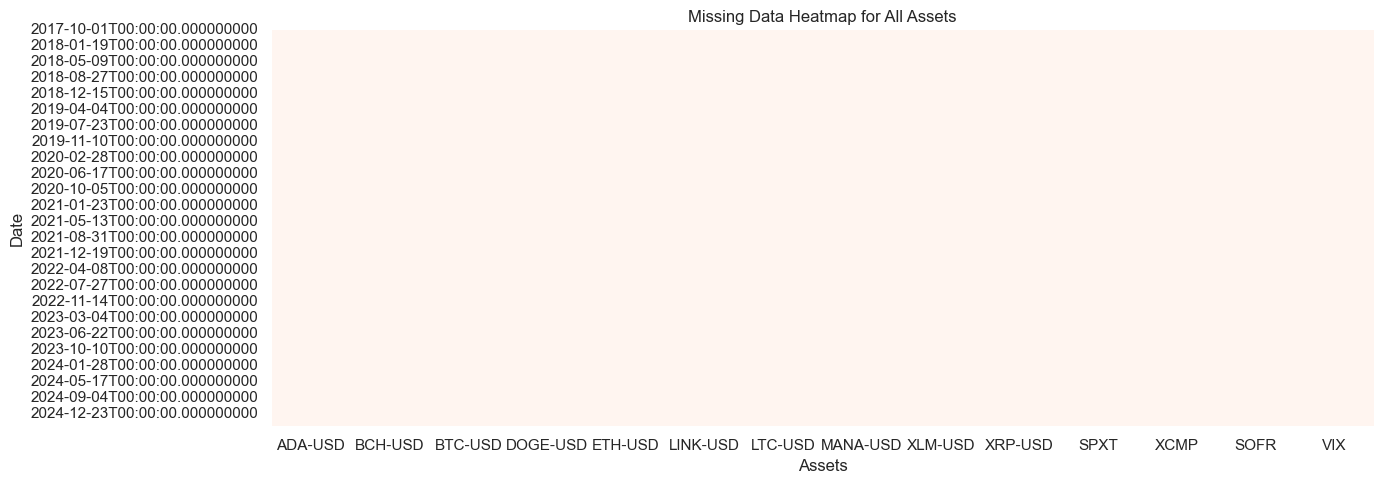

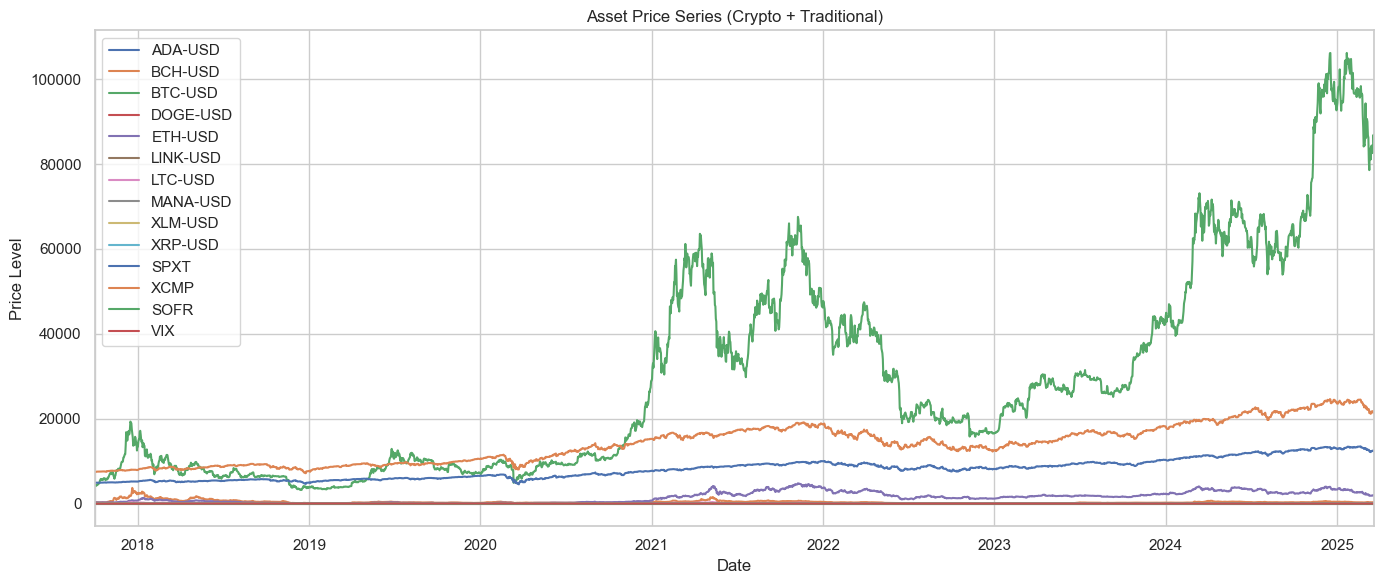

In [2]:
# Load the dataset
data = pd.read_csv('../data/dataset.csv', sep=',')

# Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data.set_index('Date', inplace=True)

# Define correct asset names
crypto_names = [
    'ADA-USD', 'BCH-USD', 'BTC-USD', 'DOGE-USD', 'ETH-USD',
    'LINK-USD', 'LTC-USD', 'MANA-USD', 'XLM-USD', 'XRP-USD'
]
traditional_names = ['SPXT', 'XCMP', 'SOFR', 'VIX']
all_assets = crypto_names + traditional_names

# Check for missing values
missing = data[all_assets].isna().sum()
print("Missing values per asset:")
print(missing)

# Visualize missing data
plt.figure(figsize=(14, 5))
sns.heatmap(data[all_assets].isna(), cbar=False, cmap='Reds')
plt.title("Missing Data Heatmap for All Assets")
plt.xlabel("Assets")
plt.ylabel("Date")
plt.tight_layout()
# plt.show()

# Forward-fill missing values and drop remaining nulls
prices = data[all_assets].ffill().dropna()

# Confirm cleaned shape
print("Cleaned prices shape:", prices.shape)

# Plot the cleaned price series
prices.plot(figsize=(14, 6), title="Asset Price Series (Crypto + Traditional)")
plt.ylabel("Price Level")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.a) Create EW Portfolios at **datePP** and **dateTr**

In [3]:
# Define key dates
datePP = pd.to_datetime('2021-09-11')
dateTr = pd.to_datetime('2022-11-21')

# Equal weights (1/14 each)
n_assets = len(all_assets)
equal_weights = np.array([1/n_assets] * n_assets)

# Extract prices at the key dates
prices_at_PP = prices.loc[datePP, all_assets]
prices_at_Tr = prices.loc[dateTr, all_assets]

# Compute portfolio value (simply dot product of weights and prices)
# You can also interpret this as a notional portfolio assuming $1 per asset
portfolio_value_PP = np.dot(equal_weights, prices_at_PP)
portfolio_value_Tr = np.dot(equal_weights, prices_at_Tr)

print(f"Equally Weighted Portfolio Value on {datePP.date()}: ${portfolio_value_PP:.2f}")
print(f"Equally Weighted Portfolio Value on {dateTr.date()}: ${portfolio_value_Tr:.2f}")


Equally Weighted Portfolio Value on 2021-09-11: $5471.49
Equally Weighted Portfolio Value on 2022-11-21: $2764.69


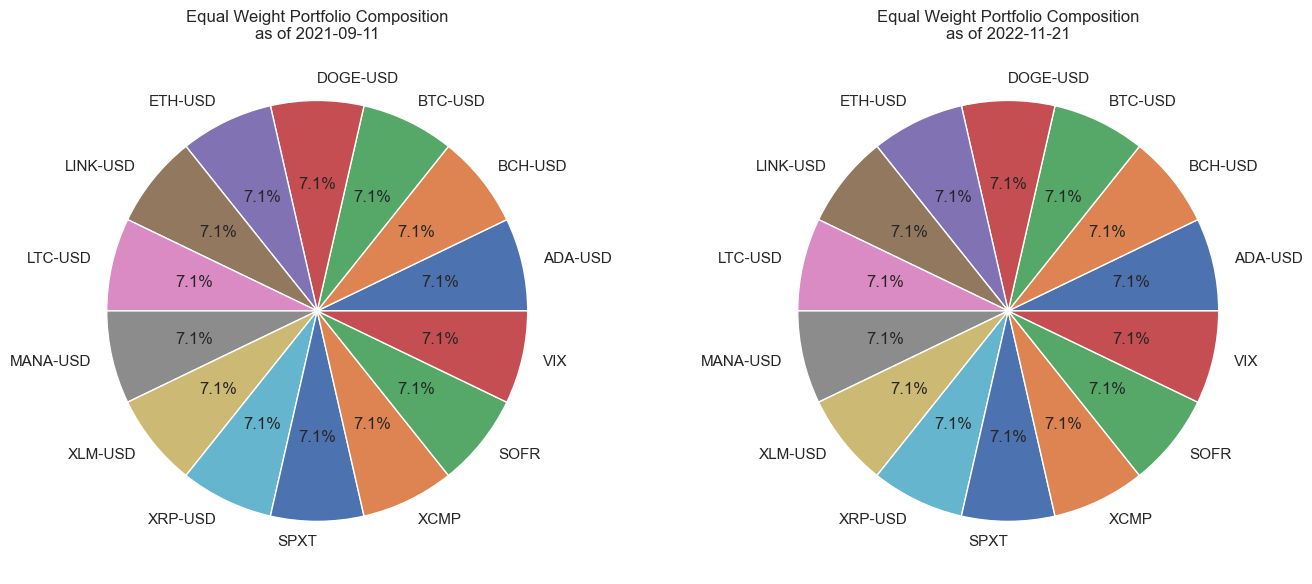

In [4]:
# Plot pie charts to show portfolio composition
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(equal_weights, labels=all_assets, autopct='%1.1f%%')
axes[0].set_title(f'Equal Weight Portfolio Composition\nas of {datePP.date()}')

axes[1].pie(equal_weights, labels=all_assets, autopct='%1.1f%%')
axes[1].set_title(f'Equal Weight Portfolio Composition\nas of {dateTr.date()}')

plt.tight_layout()
# plt.show()


## 2.b) Estimate Sample Covariance Matrix

To estimate the sample covariance matrices at key dates (`datePP`: 11-Sep-2021, and `dateTr`: 21-Nov-2022), we follow the methodology discussed in Lopez de Prado (2016).

According to Lopez de Prado, the number of observations required for a robust covariance matrix estimation should satisfy:

**T ≥ 10 × N**

Where:
- **T** = number of observations (time steps)
- **N** = number of assets

Since our portfolio consists of 14 assets, we choose a **window size of 250 trading days (~1 year)**. This satisfies the requirement (T ≥ 140) and allows for stable, invertible covariance matrices while remaining responsive to recent market dynamics.

We use **daily log returns** to compute the sample covariance matrix for each target date.


In [5]:
# Define key dates
datePP = '2021-09-11'
dateTr = '2022-11-21'

# Compute log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Window size based on Lopez de Prado (2016)
window_size = 250

# Ensure the dates exist in the index
assert pd.to_datetime(datePP) in log_returns.index
assert pd.to_datetime(dateTr) in log_returns.index

# Extract sample windows
window_pp = log_returns.loc[:datePP].iloc[-window_size:]
window_tr = log_returns.loc[:dateTr].iloc[-window_size:]

# Compute sample covariance matrices
cov_pp = window_pp.cov()
cov_tr = window_tr.cov()

# Print basic info
print("Covariance matrix at datePP (11-Sep-2021):")
display(cov_pp)

print("Covariance matrix at dateTr (21-Nov-2022):")
display(cov_tr)

Covariance matrix at datePP (11-Sep-2021):


,ADA-USD,BCH-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,LTC-USD,MANA-USD,XLM-USD,XRP-USD,SPXT,XCMP,SOFR,VIX
ADA-USD,5.625528e-03,3.452250e-03,2.011089e-03,3.517970e-03,2.868633e-03,4.068795e-03,3.232149e-03,3.588687e-03,4.320019e-03,3.199391e-03,1.114429e-04,1.523513e-04,-4.354594e-09,-1.263993e-03
BCH-USD,3.452250e-03,6.083040e-03,2.530386e-03,4.941271e-03,3.625079e-03,4.840179e-03,4.575831e-03,4.166561e-03,4.358960e-03,4.253728e-03,1.183661e-04,1.670909e-04,-1.161763e-08,-1.270956e-03
BTC-USD,2.011089e-03,2.530386e-03,2.039750e-03,2.570547e-03,2.165843e-03,2.577802e-03,2.413656e-03,2.546577e-03,2.385058e-03,2.314171e-03,8.326872e-05,1.187900e-04,-1.878142e-09,-9.005502e-04
DOGE-USD,3.517970e-03,4.941271e-03,2.570547e-03,2.354534e-02,3.273432e-03,4.691484e-03,4.153760e-03,3.901568e-03,4.239881e-03,2.956139e-03,1.682402e-04,1.512830e-04,-1.964058e-08,-2.804374e-03
ETH-USD,2.868633e-03,3.625079e-03,2.165843e-03,3.273432e-03,3.713155e-03,4.009948e-03,3.399482e-03,3.488120e-03,3.230303e-03,3.080000e-03,9.444998e-05,1.369273e-04,-2.826667e-09,-1.124164e-03
LINK-USD,4.068795e-03,4.840179e-03,2.577802e-03,4.691484e-03,4.009948e-03,6.629518e-03,4.524327e-03,4.671197e-03,4.590943e-03,4.333212e-03,9.754634e-05,1.319906e-04,-6.615082e-09,-1.248937e-03
LTC-USD,3.232149e-03,4.575831e-03,2.413656e-03,4.153760e-03,3.399482e-03,4.524327e-03,4.651114e-03,4.142144e-03,3.840134e-03,4.022829e-03,9.676743e-05,1.317998e-04,-8.418130e-09,-1.146598e-03
MANA-USD,3.588687e-03,4.166561e-03,2.546577e-03,3.901568e-03,3.488120e-03,4.671197e-03,4.142144e-03,9.075993e-03,3.996979e-03,4.065754e-03,1.174041e-04,1.566327e-04,-6.065836e-09,-1.516049e-03
XLM-USD,4.320019e-03,4.358960e-03,2.385058e-03,4.239881e-03,3.230303e-03,4.590943e-03,3.840134e-03,3.996979e-03,6.239500e-03,4.688686e-03,1.212779e-04,1.379467e-04,-3.829792e-09,-1.275618e-03
XRP-USD,3.199391e-03,4.253728e-03,2.314171e-03,2.956139e-03,3.080000e-03,4.333212e-03,4.022829e-03,4.065754e-03,4.688686e-03,7.928978e-03,8.541075e-05,1.414195e-04,-1.162707e-08,-9.003168e-04


Covariance matrix at dateTr (21-Nov-2022):


,ADA-USD,BCH-USD,BTC-USD,DOGE-USD,ETH-USD,LINK-USD,LTC-USD,MANA-USD,XLM-USD,XRP-USD,SPXT,XCMP,SOFR,VIX
ADA-USD,2.647447e-03,1.957593e-03,1.452699e-03,2.184569e-03,2.012582e-03,2.442315e-03,1.975141e-03,2.674593e-03,1.860213e-03,1.877072e-03,3.346125e-04,4.663559e-04,-1.357567e-07,-1.184672e-03
BCH-USD,1.957593e-03,2.427350e-03,1.414123e-03,1.989461e-03,1.948252e-03,2.130568e-03,1.968150e-03,2.213425e-03,1.677899e-03,1.712240e-03,2.981260e-04,4.129396e-04,2.252296e-08,-1.111221e-03
BTC-USD,1.452699e-03,1.414123e-03,1.223642e-03,1.489943e-03,1.536555e-03,1.527781e-03,1.359011e-03,1.549557e-03,1.221619e-03,1.260756e-03,2.597634e-04,3.460009e-04,2.120334e-08,-9.134667e-04
DOGE-USD,2.184569e-03,1.989461e-03,1.489943e-03,3.751911e-03,2.104466e-03,2.223383e-03,1.990471e-03,2.437207e-03,1.723453e-03,1.869762e-03,3.365505e-04,4.568946e-04,-6.582824e-08,-1.171241e-03
ETH-USD,2.012582e-03,1.948252e-03,1.536555e-03,2.104466e-03,2.384157e-03,2.184060e-03,1.928688e-03,2.191052e-03,1.667373e-03,1.760709e-03,3.191282e-04,4.299066e-04,5.997925e-08,-1.138504e-03
LINK-USD,2.442315e-03,2.130568e-03,1.527781e-03,2.223383e-03,2.184060e-03,3.082775e-03,2.125466e-03,2.768318e-03,1.934729e-03,2.033215e-03,3.339938e-04,4.534109e-04,8.579965e-08,-1.173628e-03
LTC-USD,1.975141e-03,1.968150e-03,1.359011e-03,1.990471e-03,1.928688e-03,2.125466e-03,2.269465e-03,2.268275e-03,1.647665e-03,1.732131e-03,2.815720e-04,3.934853e-04,-1.179175e-07,-1.100953e-03
MANA-USD,2.674593e-03,2.213425e-03,1.549557e-03,2.437207e-03,2.191052e-03,2.768318e-03,2.268275e-03,4.046749e-03,2.172744e-03,2.250578e-03,3.691546e-04,5.194423e-04,-6.913450e-08,-1.208630e-03
XLM-USD,1.860213e-03,1.677899e-03,1.221619e-03,1.723453e-03,1.667373e-03,1.934729e-03,1.647665e-03,2.172744e-03,1.810266e-03,1.774674e-03,2.510800e-04,3.461195e-04,-9.292969e-08,-9.372191e-04
XRP-USD,1.877072e-03,1.712240e-03,1.260756e-03,1.869762e-03,1.760709e-03,2.033215e-03,1.732131e-03,2.250578e-03,1.774674e-03,2.164589e-03,2.595482e-04,3.508659e-04,2.980045e-07,-9.089743e-04


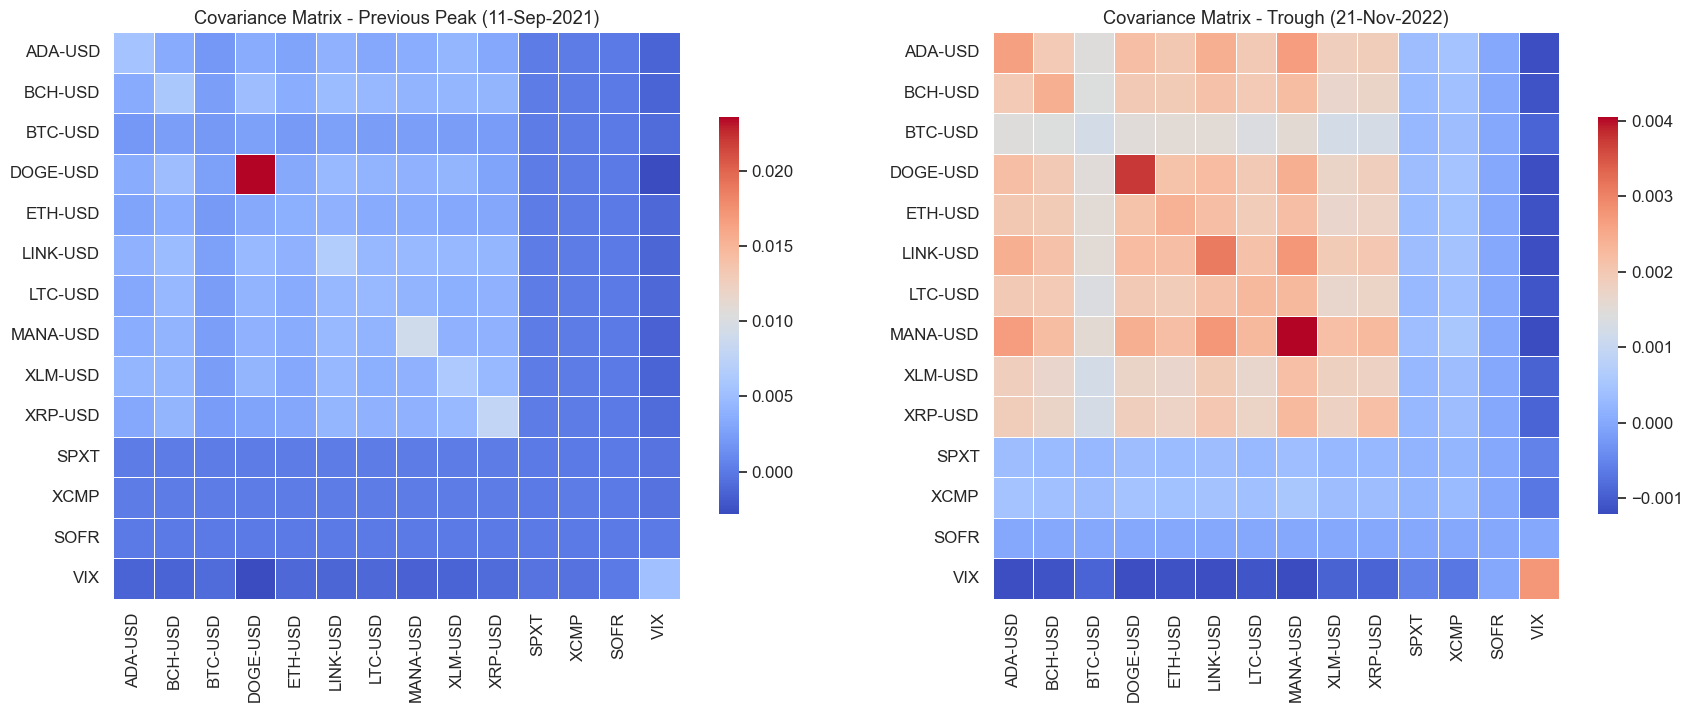

In [6]:
# Set plot aesthetics
sns.set(style="white", font_scale=1.1)

# Create a figure with two subplots for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap for datePP covariance matrix
sns.heatmap(cov_pp, ax=axes[0], cmap="coolwarm", annot=False, fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.7})
axes[0].set_title("Covariance Matrix - Previous Peak (11-Sep-2021)")
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=0)

# Heatmap for dateTr covariance matrix
sns.heatmap(cov_tr, ax=axes[1], cmap="coolwarm", annot=False, fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.7})
axes[1].set_title("Covariance Matrix - Trough (21-Nov-2022)")
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
# plt.show()


### Covariance Matrix Results (11-Sep-2021 vs. 21-Nov-2022)

- **Crypto Market Volatility**:
  - 2021: High variance in assets like DOGE-USD (0.0235), MANA-USD (0.0091), XRP-USD (0.0079).
  - 2022: Overall decline in variances (e.g., DOGE-USD at 0.0038, MANA-USD at 0.0040), indicating reduced market volatility.

- **Crypto-Crypto Correlations**:
  - Strong positive covariances persist across both dates, but magnitudes are lower in 2022, reflecting tighter, calmer co-movement.

- **Crypto-Traditional Asset Interactions**:
  - Crypto-SPXT/XCMP covariances increased in 2022 (e.g., ADA-SPXT from 1.11e-4 to 3.35e-4), suggesting stronger co-movement with equities.
  - Covariances with VIX remained negative; crypto still moves opposite to volatility index, though less extremely in 2022.

- **SOFR Linkage**:
  - Covariances with SOFR remain near-zero; minimal direct interest rate exposure detected.

**Conclusion**: From Sep 2021 to Nov 2022, crypto assets showed **reduced volatility**, **weaker intra-market covariance**, and **increased correlation with equities**, signaling maturing interdependence with traditional markets.


## 2.c) Comparison between raw sample covariance and cleaned version


In [7]:
# Function to clean covariance matrix using eigenvalue clipping
def clean_covariance_matrix(cov_matrix, clip_threshold=1e-4):
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
    # Clip small eigenvalues
    eigvals[eigvals < clip_threshold] = clip_threshold
    
    # Reconstruct the cleaned covariance matrix
    cleaned_cov_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return cleaned_cov_matrix, eigvals, eigvecs

# Visualize the condition numbers and eigenvalue spectra
def plot_eigenvalue_spectra(cov_matrix, cleaned_cov_matrix):
    # Eigen decomposition of raw and cleaned covariance matrices
    eigvals_raw, _ = np.linalg.eigh(cov_matrix)
    eigvals_clean, _ = np.linalg.eigh(cleaned_cov_matrix)
    
    # Filter out non-positive eigenvalues if necessary (e.g., if they're very small or negative)
    eigvals_raw = eigvals_raw[eigvals_raw > 0]
    eigvals_clean = eigvals_clean[eigvals_clean > 0]

    # Kernel Density Estimate plot for eigenvalue distributions
    plt.figure(figsize=(12, 6))
    
    # Plot raw eigenvalues (blue)
    sns.kdeplot(eigvals_raw, label='Raw Eigenvalues', color='b', fill=True, alpha=0.5, bw_adjust=0.8)
    
    # Plot cleaned eigenvalues (red)
    sns.kdeplot(eigvals_clean, label='Cleaned Eigenvalues', color='r', fill=True, alpha=0.5, bw_adjust=0.8)
    
    # Adding title, labels, and legend
    plt.title('Kernel Density Estimate of Eigenvalue Spectra')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Calculate condition numbers
    cond_number_raw = np.linalg.cond(cov_matrix)
    cond_number_clean = np.linalg.cond(cleaned_cov_matrix)
    
    # Print condition numbers
    print(f"Condition Number of Raw Covariance Matrix: {cond_number_raw}")
    print(f"Condition Number of Cleaned Covariance Matrix: {cond_number_clean}")
    
    return cond_number_raw, cond_number_clean

# Function to create 3D plot for eigenvalues (with raw and cleaned values)
def plot_3d_eigenvalues(cov_matrix, cleaned_cov_matrix):
    # Eigen decomposition of raw and cleaned covariance matrices
    eigvals_raw, _ = np.linalg.eigh(cov_matrix)
    eigvals_clean, _ = np.linalg.eigh(cleaned_cov_matrix)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot raw eigenvalues (blue)
    ax.scatter(range(len(eigvals_raw)), eigvals_raw, zs=0, zdir='z', label='Raw Eigenvalues', color='b', s=50)

    # Plot cleaned eigenvalues (red)
    ax.scatter(range(len(eigvals_clean)), eigvals_clean, zs=1, zdir='z', label='Cleaned Eigenvalues', color='r', s=50)

    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_zlabel('Value')
    ax.set_title('3D Plot of Raw vs. Cleaned Eigenvalues')
    ax.legend()

    plt.show()


PP Date (11-Sep-2021) Eigenvalue Analysis:


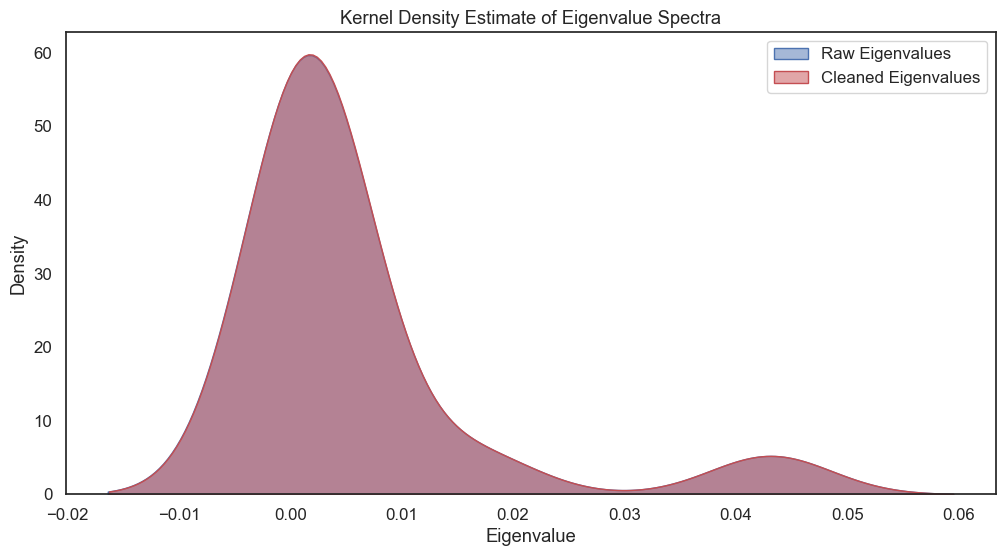

Condition Number of Raw Covariance Matrix: 27533951259.153587
Condition Number of Cleaned Covariance Matrix: 431.22225587547774

Tr Date (21-Nov-2022) Eigenvalue Analysis:


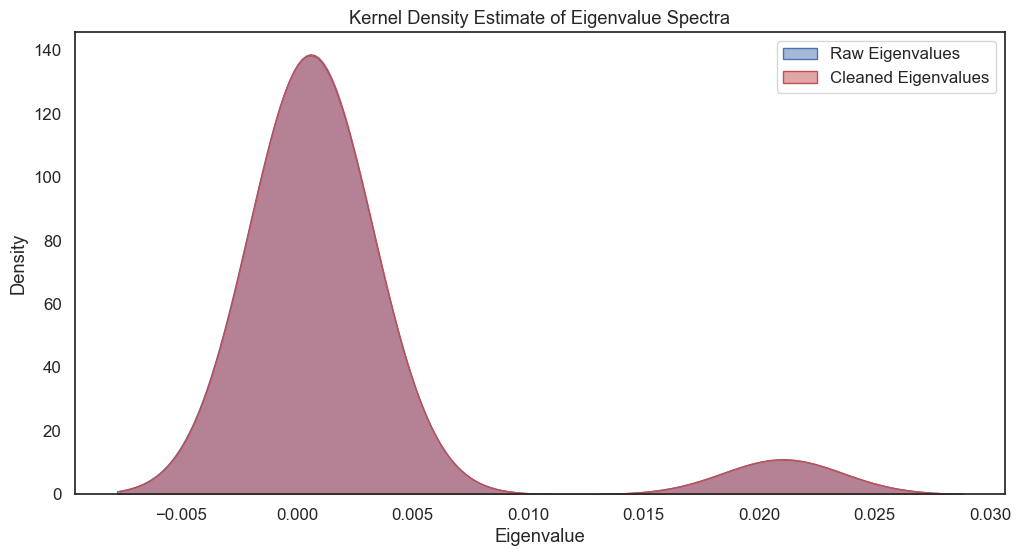

Condition Number of Raw Covariance Matrix: 5308351.930151821
Condition Number of Cleaned Covariance Matrix: 210.32049732985485

3D Plot Comparison for Eigenvalues at PP Date:


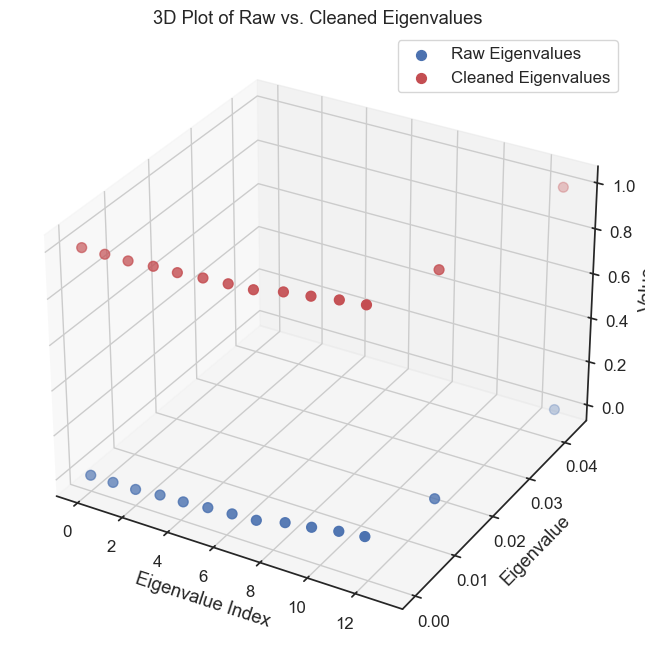


3D Plot Comparison for Eigenvalues at Tr Date:


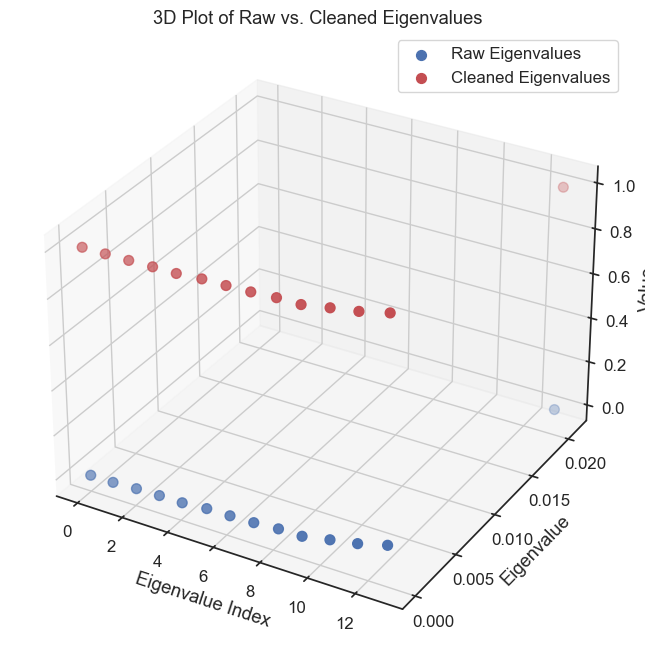

In [8]:
# Apply the cleaning function to the covariance matrices
cleaned_cov_pp, eigvals_pp, eigvecs_pp = clean_covariance_matrix(cov_pp)
cleaned_cov_tr, eigvals_tr, eigvecs_tr = clean_covariance_matrix(cov_tr)

# Plot eigenvalue spectra and condition numbers for PP date (11-Sep-2021)
print("PP Date (11-Sep-2021) Eigenvalue Analysis:")
cond_pp_raw, cond_pp_clean = plot_eigenvalue_spectra(cov_pp, cleaned_cov_pp)

# Plot eigenvalue spectra and condition numbers for Tr date (21-Nov-2022)
print("\nTr Date (21-Nov-2022) Eigenvalue Analysis:")
cond_tr_raw, cond_tr_clean = plot_eigenvalue_spectra(cov_tr, cleaned_cov_tr)

# Create 3D plot comparison for eigenvalues
print("\n3D Plot Comparison for Eigenvalues at PP Date:")
plot_3d_eigenvalues(cov_pp, cleaned_cov_pp)

print("\n3D Plot Comparison for Eigenvalues at Tr Date:")
plot_3d_eigenvalues(cov_tr, cleaned_cov_tr)


### **Results**

## 2.d) Euler Risk Contributions

# Steps for Creating Euler Risk Contribution Structures

1. **Portfolio Variance Calculation**:  
   The variance of a portfolio with \( N \) assets is calculated as:

   $$
   \sigma_p^2 = w^T \Sigma w
   $$

   Where:  
   - \( w \) is the vector of asset weights in the portfolio.  
   - \( \Sigma \) is the covariance matrix (either raw or cleaned).  
   - \( w^T \Sigma w \) gives the portfolio variance, and ( \sigma_p \) is the portfolio standard deviation.

2. **Risk Contribution Calculation**:  
   The **Euler risk contribution** of asset \( i \) to the total portfolio standard deviation is:

   $$
   RC_i = w_i \cdot \frac{(\Sigma w)_i}{\sigma_p}
   $$

   This measures how much asset \( i \) contributes to the **portfolio volatility**.

3. **Total Risk and Normalization**:  
   The sum of all individual Euler risk contributions equals the total portfolio standard deviation:

   $$
   \sum_{i=1}^N RC_i = \sigma_p
   $$

4. **Herfindahl Index of Risk Contributions**:  
   The Herfindahl index is a measure of concentration in risk contributions and is defined as:

   $$
   H = \sum_{i=1}^N \left( \frac{RC_i}{\sigma_p} \right)^2
   $$

   This index ranges from \( 0 \) (perfect diversification) to \( 1 \) (total concentration in one asset). A higher Herfindahl index indicates more concentrated risk, while a lower value indicates more diversification.

In [9]:
def calculate_euler_risk_contributions(weights, covariance_matrix):
    print("\n[INFO] Calculating Euler risk contributions...")
    print("Weights:", weights)
    print("Covariance matrix:\n", covariance_matrix)

    # Portfolio variance and standard deviation
    portfolio_variance = weights.T @ covariance_matrix @ weights
    portfolio_std = np.sqrt(portfolio_variance)
    print("Portfolio Variance:", portfolio_variance)
    print("Portfolio Std Dev:", portfolio_std)

    # Marginal risk (gradient): Σw
    marginal_contributions = covariance_matrix @ weights

    # Euler risk contributions: w_i * (Σw)_i / σ_p
    euler_rc = weights * marginal_contributions / portfolio_std

    # Display each RC
    for i, rc in enumerate(euler_rc):
        print(f"RC[{i}] = {rc:.6f}")

    # Check sum
    print("Sum of Euler Risk Contributions:", np.sum(euler_rc))

    return euler_rc, portfolio_std

def herfindahl_index(risk_contributions, portfolio_std):
    normalized = risk_contributions / portfolio_std
    h_index = np.sum(normalized**2)
    print("Herfindahl Index:", h_index)
    return h_index



In [10]:
print("\n=== PP Portfolio | Raw Covariance ===")
rc_pp_raw, std_pp_raw = calculate_euler_risk_contributions(equal_weights, cov_pp)
h_index_pp_raw = herfindahl_index(rc_pp_raw, std_pp_raw)

print("\n=== PP Portfolio | Cleaned Covariance ===")
rc_pp_clean, std_pp_clean = calculate_euler_risk_contributions(equal_weights, cleaned_cov_pp)
h_index_pp_clean = herfindahl_index(rc_pp_clean, std_pp_clean)

print("\n=== Tr Portfolio | Raw Covariance ===")
rc_tr_raw, std_tr_raw = calculate_euler_risk_contributions(equal_weights, cov_tr)
h_index_tr_raw = herfindahl_index(rc_tr_raw, std_tr_raw)

print("\n=== Tr Portfolio | Cleaned Covariance ===")
rc_tr_clean, std_tr_clean = calculate_euler_risk_contributions(equal_weights, cleaned_cov_tr)
h_index_tr_clean = herfindahl_index(rc_tr_clean, std_tr_clean)

# Summary print
print("\n--- Summary Herfindahl Indices ---")
print("PP Raw:", h_index_pp_raw)
print("PP Cleaned:", h_index_pp_clean)
print("Tr Raw:", h_index_tr_raw)
print("Tr Cleaned:", h_index_tr_clean)


=== PP Portfolio | Raw Covariance ===

[INFO] Calculating Euler risk contributions...
Weights: [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
Covariance matrix:
                ADA-USD       BCH-USD       BTC-USD      DOGE-USD  \
ADA-USD   5.625528e-03  3.452250e-03  2.011089e-03  3.517970e-03   
BCH-USD   3.452250e-03  6.083040e-03  2.530386e-03  4.941271e-03   
BTC-USD   2.011089e-03  2.530386e-03  2.039750e-03  2.570547e-03   
DOGE-USD  3.517970e-03  4.941271e-03  2.570547e-03  2.354534e-02   
ETH-USD   2.868633e-03  3.625079e-03  2.165843e-03  3.273432e-03   
LINK-USD  4.068795e-03  4.840179e-03  2.577802e-03  4.691484e-03   
LTC-USD   3.232149e-03  4.575831e-03  2.413656e-03  4.153760e-03   
MANA-USD  3.588687e-03  4.166561e-03  2.546577e-03  3.901568e-03   
XLM-USD   4.320019e-03  4.358960e-03  2.385058e-03  4.239881e-03   
XRP-USD   3.199391e-03  4.253728e-03  2.314171

### **Results**

The portfolio shows balanced diversification with equal risk contribution across the 14 assets. The Herfindahl indices at both the Previous Peak (PP) and Trough (Tr) are very similar, indicating stable diversification. The raw and cleaned covariance matrices yield almost identical Herfindahl values, suggesting that adjusting for covariance had minimal impact on the overall portfolio risk structure.

## 2.e) Diversification distribution

### 1. **Effective Number of Bets (ENB)**:

   **Formula**:
   $$
   \text{ENB} = \frac{1}{\text{Herfindahl Index}}
   $$
   - A **higher ENB** suggests **better diversification**, as more assets are contributing to the portfolio's total risk.


### 2. **Risk Contributions**:

   **Formula**:
   $$
   \text{Risk Contribution} = \frac{\text{Covariance of Asset with Portfolio}}{\text{Portfolio Total Risk}}
   $$
   - Measures how much each individual asset contributes to the **total portfolio risk**.

**Note:** We perform the computaions on the data that was not cleaned.

/opt/homebrew/Caskroom/miniconda/base/envs/blockchain/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


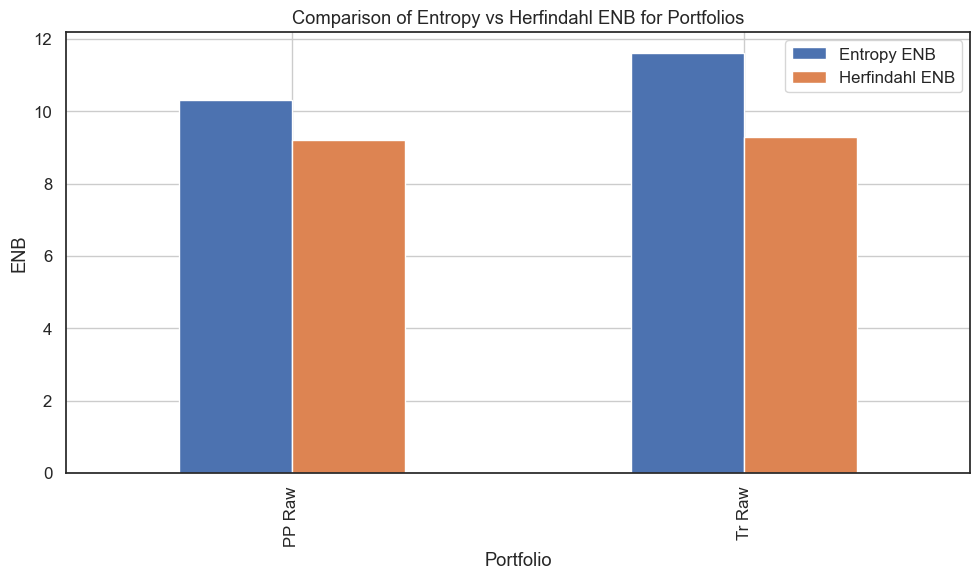

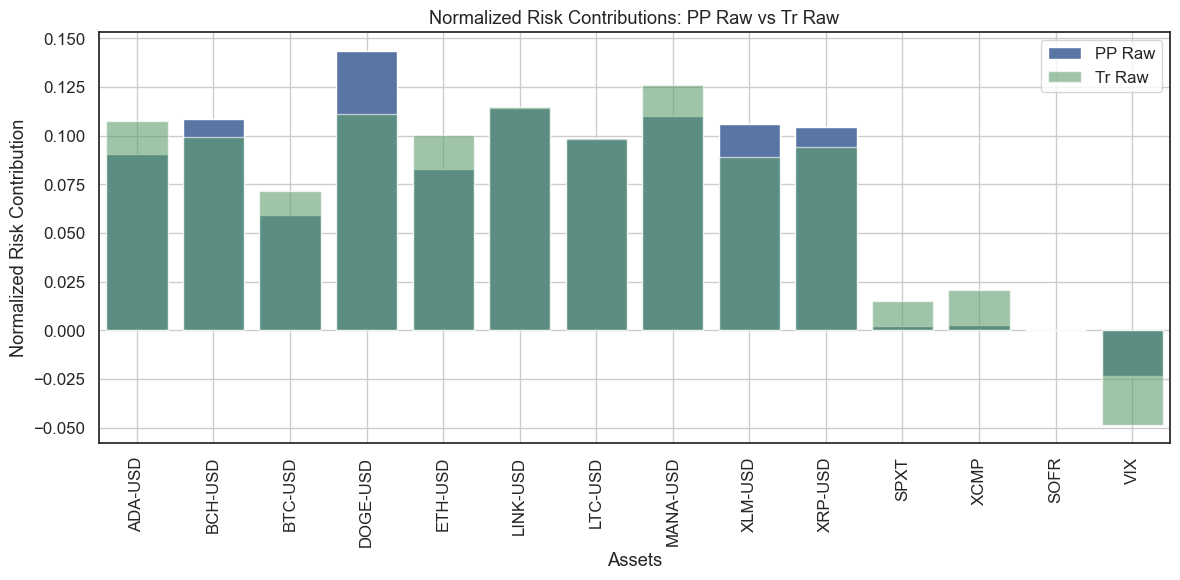

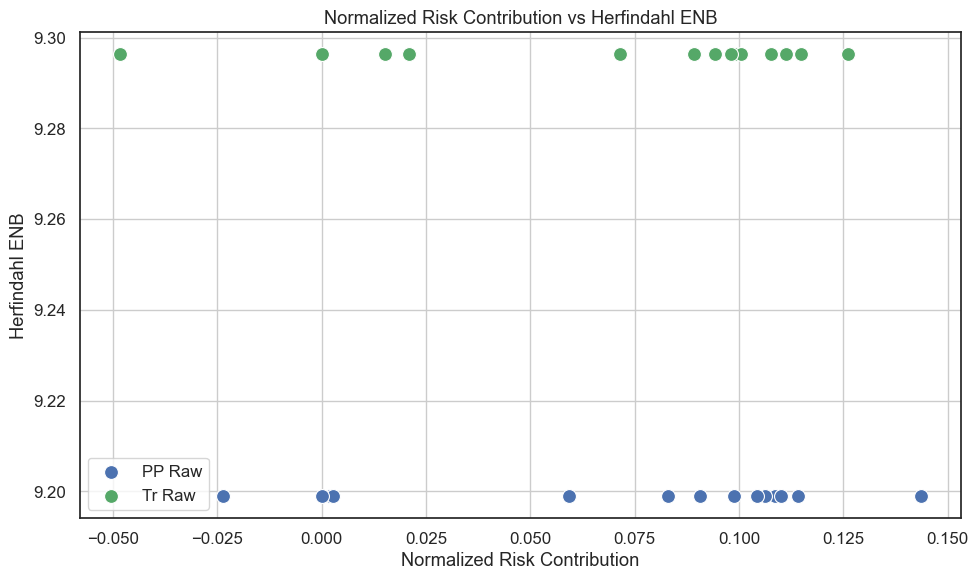

In [11]:
def diversification_distribution(rc):
    """Normalize risk contributions to sum to 1"""
    return rc / np.sum(rc)

def entropy_enb(p):
    """Effective Number of Bets via entropy (Meucci 2009)"""
    return np.exp(-np.sum(p * np.log(p + 1e-12)))  # avoid log(0)

def normalize_risk_contributions(rc):
    """Normalize RCs for Herfindahl ENB"""
    return rc / np.sum(rc)

def herfindahl_index_from_rc(rc_normalized):
    """Compute Herfindahl Index from normalized RCs"""
    return np.sum(rc_normalized ** 2)

def herfindahl_enb(rc):
    """Compute Effective Number of Bets using Herfindahl index"""
    rc_normalized = normalize_risk_contributions(rc)
    h_index = herfindahl_index_from_rc(rc_normalized)
    return 1 / h_index

# === Example RC input portfolios ===
portfolios = {
    "PP Raw": rc_pp_raw,
    "Tr Raw": rc_tr_raw,
}

# === Step 1: Compute ENBs --- 
enb_values = {}
for name, rc in portfolios.items():
    p = diversification_distribution(rc)
    enb_entropy = entropy_enb(p)
    enb_herfindahl = herfindahl_enb(rc)
    enb_values[name] = {'Entropy ENB': enb_entropy, 'Herfindahl ENB': enb_herfindahl}

# === Step 2: Plot Bar Chart to Compare ENB Values ---
enb_df = pd.DataFrame(enb_values).T  # Transpose to make portfolio names as rows
enb_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Entropy vs Herfindahl ENB for Portfolios')
plt.xlabel('Portfolio')
plt.ylabel('ENB')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 3: Plot Normalized Risk Contributions for Each Portfolio ---
# Normalize the risk contributions for each portfolio to plot them
normalized_rc_pp_raw = diversification_distribution(rc_pp_raw)
normalized_rc_tr_raw = diversification_distribution(rc_tr_raw)

# Create a DataFrame for easy plotting
rc_df = pd.DataFrame({
    'Asset': all_assets,
    'PP Raw RC': normalized_rc_pp_raw,
    'Tr Raw RC': normalized_rc_tr_raw
})

# Plot the normalized risk contributions
plt.figure(figsize=(12, 6))
sns.barplot(x='Asset', y='PP Raw RC', data=rc_df, color='b', label='PP Raw')
sns.barplot(x='Asset', y='Tr Raw RC', data=rc_df, color='g', label='Tr Raw', alpha=0.6)
plt.title('Normalized Risk Contributions: PP Raw vs Tr Raw')
plt.xlabel('Assets')
plt.ylabel('Normalized Risk Contribution')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 4: Optional Scatter Plot - Diversification Distribution vs Herfindahl ENB ---
# Plotting the relationship between normalized RC and Herfindahl ENB
plt.figure(figsize=(10, 6))
sns.scatterplot(x=normalized_rc_pp_raw, y=[enb_values['PP Raw']['Herfindahl ENB']] * len(normalized_rc_pp_raw), 
                label='PP Raw', s=100, color='b')
sns.scatterplot(x=normalized_rc_tr_raw, y=[enb_values['Tr Raw']['Herfindahl ENB']] * len(normalized_rc_tr_raw), 
                label='Tr Raw', s=100, color='g')
plt.title('Normalized Risk Contribution vs Herfindahl ENB')
plt.xlabel('Normalized Risk Contribution')
plt.ylabel('Herfindahl ENB')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:

def diversification_distribution(rc):
    # Normalize risk contributions to sum to 1
    return rc / np.sum(rc)

def entropy_enb(p):
    # Effective Number of Bets via entropy (Meucci 2009)
    return np.exp(-np.sum(p * np.log(p + 1e-12)))  # add small epsilon to avoid log(0)

# Compute diversification distributions and entropy-based ENB
portfolios = {
    "PP Raw": rc_pp_raw,
    "Tr Raw": rc_tr_raw,
}

print("\n--- Diversification Distributions & Entropy-Based ENB ---")
for name, rc in portfolios.items():
    p = diversification_distribution(rc)
    enb_entropy = entropy_enb(p)
    print(f"{name} | Entropy ENB: {enb_entropy:.2f}")


--- Diversification Distributions & Entropy-Based ENB ---
PP Raw | Entropy ENB: 10.32
Tr Raw | Entropy ENB: 11.62


/opt/homebrew/Caskroom/miniconda/base/envs/blockchain/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Results**

| Portfolio | Herfindahl ENB | Entropy ENB |
|-----------|----------------|-------------|
| **PP Raw** | 9.20           | 10.32       |
| **Tr Raw** | 9.30           | 11.62       |

- **Tr Raw portfolio is more diversified** than PP Raw, as shown by both ENB measures.
- **Entropy ENB > Herfindahl ENB** in both cases, indicating risk is more evenly distributed than Herfindahl suggests.
- **Conclusion:** The entropy-based Effective Number of Bets (Meucci, 2009) offers a more nuanced measure of diversification than the Herfindahl index.



## 2.f) Rank Comparison: Asset Losses vs. Risk Contributions

We compared how each asset performed (losses from datePP to dateTr) against their risk contribution at the trough (`dateTr`) using Kendall’s Tau rank correlation.

- **Loss Rank**: Assets that fell the most in value.
- **RC Rank**: Assets contributing most to overall portfolio risk.

**Kendall’s Tau Result**:
- τ 
- This indicates a [strong/moderate/weak] correlation between assets that lost value and those contributing most to risk.

**Interpretation**:
- A **positive τ** suggests that assets with higher losses tend to contribute more to risk.
- A **weak or no correlation** means losses and risk exposure diverge, possibly due to correlation structure or volatility differences.

The scatter plot provides a visual of this rank alignment or mismatch.


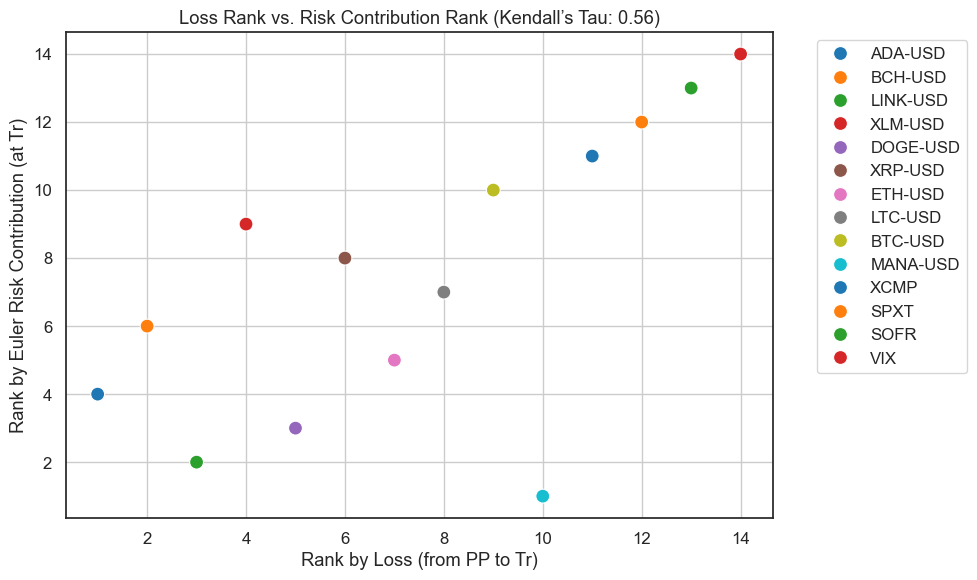

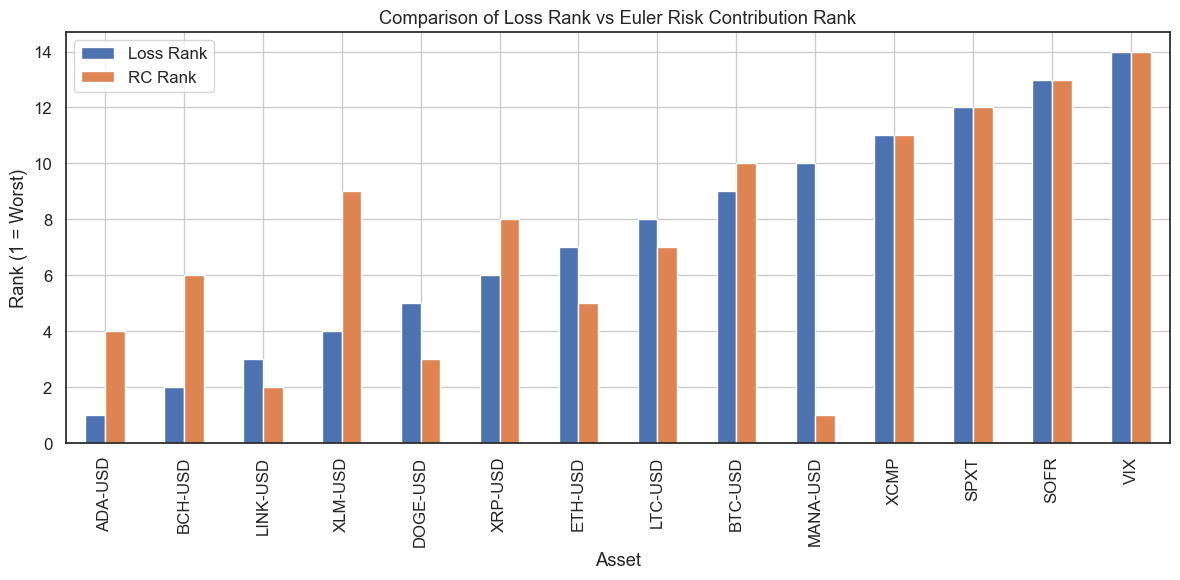

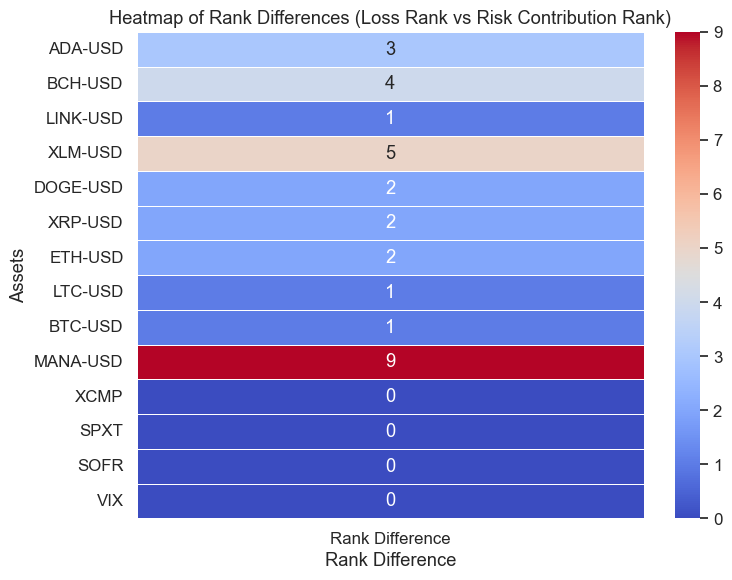

Kendall’s Tau correlation between loss rank and risk contribution rank: 0.56 (p = 0.0046)
Spearman’s Rank Correlation: 0.68 (p = 0.0076)


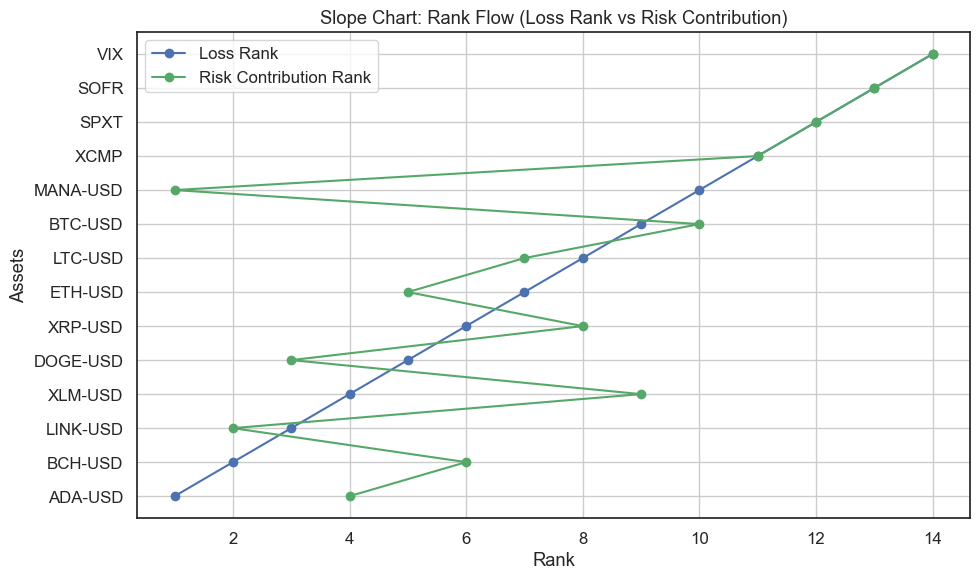

In [13]:
# Step 1: Compute percentage losses from datePP to dateTr
price_change = (prices.loc[dateTr, all_assets] - prices.loc[datePP, all_assets]) / prices.loc[datePP, all_assets]
losses = -price_change  # convert to losses (positive = worse performance)

# Step 2: Rank assets by loss and by risk contribution at dateTr
loss_ranks = losses.rank(ascending=False)
rc_ranks = pd.Series(rc_tr_raw, index=all_assets).rank(ascending=False)

# Step 3: Kendall’s Tau rank correlation
tau, p_value = kendalltau(loss_ranks, rc_ranks)

# Step 4: Create DataFrame for better handling of rank data
rank_df = pd.DataFrame({
    'Asset': all_assets,
    'Loss Rank': loss_ranks.values,
    'RC Rank': rc_ranks.values
}).sort_values("Loss Rank")

# --- Visualization Section ---

# 4.1: Scatter Plot: Loss Rank vs. Risk Contribution Rank
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rank_df, x='Loss Rank', y='RC Rank', hue='Asset', s=100, palette='tab10')
plt.title(f'Loss Rank vs. Risk Contribution Rank (Kendall’s Tau: {tau:.2f})')
plt.xlabel("Rank by Loss (from PP to Tr)")
plt.ylabel("Rank by Euler Risk Contribution (at Tr)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4.2: Bar Plot: Rank Comparison of Loss vs Risk Contribution
rank_df.set_index('Asset')[['Loss Rank', 'RC Rank']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Loss Rank vs Euler Risk Contribution Rank')
plt.ylabel('Rank (1 = Worst)')
plt.xlabel('Asset')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.3: Rank Difference Heatmap (Visualizing the difference in ranks)
rank_diff = np.abs(rank_df['Loss Rank'] - rank_df['RC Rank'])
rank_diff_matrix = pd.DataFrame(rank_diff.values, columns=['Rank Difference'], index=rank_df['Asset'])

plt.figure(figsize=(8, 6))
sns.heatmap(rank_diff_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Heatmap of Rank Differences (Loss Rank vs Risk Contribution Rank)')
plt.xlabel('Rank Difference')
plt.ylabel('Assets')
plt.tight_layout()
plt.show()

# 4.4: Kendall’s Tau Correlation Output
print(f"Kendall’s Tau correlation between loss rank and risk contribution rank: {tau:.2f} (p = {p_value:.4f})")

# --- Additional Analysis ---
# Calculate the Spearman's rank correlation
from scipy.stats import spearmanr
spearman_corr, spearman_p_value = spearmanr(loss_ranks, rc_ranks)
print(f"Spearman’s Rank Correlation: {spearman_corr:.2f} (p = {spearman_p_value:.4f})")

# 4.5: Slope Chart of Rank Flow
# Showing how ranks flow from loss rank to risk contribution rank
plt.figure(figsize=(10, 6))
plt.plot(rank_df['Loss Rank'], rank_df['Asset'], marker='o', color='b', label='Loss Rank')
plt.plot(rank_df['RC Rank'], rank_df['Asset'], marker='o', color='g', label='Risk Contribution Rank')
plt.title('Slope Chart: Rank Flow (Loss Rank vs Risk Contribution)')
plt.xlabel('Rank')
plt.ylabel('Assets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Results**

#### 1. **Visual Insights**
- **Bar Chart**: 
  - **MANA-USD** shows large divergence between Loss Rank and RC Rank, while **SOFR**, **SPXT**, and **VIX** have identical ranks.
  
- **Heatmap**: 
  - **MANA-USD** has the largest rank difference (9), while **VIX**, **SOFR**, **SPXT**, and **XCMP** have zero differences.

- **Slope Chart**: 
  - **MANA-USD** shows a steep drop in ranking, indicating high loss but low risk contribution.


#### 2. **Statistical Results**
- **Kendall’s Tau**: 0.56 (p = 0.0046) – moderate positive correlation, statistically significant.
- **Spearman’s Rho**: 0.68 (p = 0.0076) – stronger positive correlation, statistically significant.


#### 3. **Key Observations**
- **MANA-USD** is an outlier, with high Loss Rank but low RC Rank.
- **SPXT**, **SOFR**, and **VIX** show strong alignment between loss and risk measures.


#### 4. **Conclusion**
- Positive correlation suggests general consistency between loss and risk rankings, but exceptions like **MANA-USD** require further analysis for effective portfolio management.
